# 04 – Federated Learning Experiments

Train multimodal health risk model using Federated Learning with real data across simulated nodes (hospitals/cities).

**What this notebook does:**
- Loads your processed data (Fitbit, air quality, weather)
- Partitions data across 3 nodes
- Trains using Federated Averaging (FedAvg)
- Evaluates and visualizes results

## Setup

In [29]:
import sys
sys.path.insert(0, '../src')

# Force reload modules to get latest changes
import importlib
if 'federated_health_risk.data.federated_loader' in sys.modules:
    importlib.reload(sys.modules['federated_health_risk.data.federated_loader'])

import logging
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

from federated_health_risk.data.federated_loader import prepare_federated_data
from federated_health_risk.models.multimodal_model import MultimodalRiskNet

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

print("✓ Imports successful")

✓ Imports successful


## 1. Load Federated Data

In [30]:
# Configuration
NUM_NODES = 3
STRATEGY = "iid"  # or "non_iid" for temporal/geographic differences

# Prepare data for all nodes
print(f"Loading data for {NUM_NODES} nodes with {STRATEGY} strategy...")
node_loaders = prepare_federated_data(
    num_nodes=NUM_NODES, 
    strategy=STRATEGY, 
    data_root="../data/processed"
)

# Get dimensions from first node
_, _, (vitals_dim, air_dim, weather_dim) = node_loaders[0]

print(f"\n📊 Data Summary:")
print(f"  Nodes: {NUM_NODES}")
print(f"  Strategy: {STRATEGY}")
print(f"  Input dimensions:")
print(f"    - Vitals: {vitals_dim} features")
print(f"    - Air Quality: {air_dim} features")
print(f"    - Weather: {weather_dim} features")

# Show data distribution per node
for node_id in range(NUM_NODES):
    train_loader, test_loader, _ = node_loaders[node_id]
    train_samples = len(train_loader.dataset)
    test_samples = len(test_loader.dataset)
    print(f"  Node {node_id}: {train_samples} train, {test_samples} test samples")

INFO:federated_health_risk.data.federated_loader:Loading processed data from ..\data\processed
INFO:federated_health_risk.data.federated_loader:Loaded: Fitbit=940, Air=940, Weather=940 rows
INFO:federated_health_risk.data.federated_loader:Synthetic merged dataset: 940 rows, 19 columns
c:\Users\Sahal Saeed\Documents\7semester\mlops\project_cursor\.venv\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
INFO:federated_health_risk.data.federated_loader:Risk distribution: 50.00% high-risk samples
c:\Users\Sahal Saeed\Documents\7semester\mlops\project_cursor\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
INFO:federated_health_risk.data.federated_loader:Node 0: 314 samples, risk=50.00%
INFO:federated_health_risk.data.federated_loader:

Loading data for 3 nodes with iid strategy...

📊 Data Summary:
  Nodes: 3
  Strategy: iid
  Input dimensions:
    - Vitals: 6 features
    - Air Quality: 5 features
    - Weather: 4 features
  Node 0: 251 train, 63 test samples
  Node 1: 250 train, 63 test samples
  Node 2: 250 train, 63 test samples


In [31]:
# Show unique label counts for each node's train and test sets
for node_id in range(NUM_NODES):
    train_loader, test_loader, _ = node_loaders[node_id]
    y_train = []
    y_test = []
    for batch in train_loader:
        *_, y = batch
        y_train.extend(y.cpu().numpy().flatten())
    for batch in test_loader:
        *_, y = batch
        y_test.extend(y.cpu().numpy().flatten())
    print(f"Node {node_id}:")
    print("  Train label counts:", {v: int((y_train == v).sum()) for v in set(y_train)})
    print("  Test label counts: ", {v: int((y_test == v).sum()) for v in set(y_test)})

Node 0:
  Train label counts: {0.0: 125, 1.0: 126}
  Test label counts:  {0.0: 32, 1.0: 31}
Node 1:
  Train label counts: {0.0: 133, 1.0: 117}
  Test label counts:  {0.0: 33, 1.0: 30}
Node 2:
  Train label counts: {0.0: 117, 1.0: 133}
  Test label counts:  {0.0: 30, 1.0: 33}


## 2. Initialize Models

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create model for each node
node_models = {}
node_optimizers = {}

for node_id in range(NUM_NODES):
    model = MultimodalRiskNet(
        vitals_dim=vitals_dim, 
        air_dim=air_dim, 
        text_dim=weather_dim
    )
    model = model.to(device)
    node_models[node_id] = model
    node_optimizers[node_id] = Adam(model.parameters(), lr=1e-3)

total_params = sum(p.numel() for p in node_models[0].parameters())
trainable_params = sum(p.numel() for p in node_models[0].parameters() if p.requires_grad)

print(f"\n🧠 Model Architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Initialized {NUM_NODES} independent models")

Using device: cpu

🧠 Model Architecture:
  Total parameters: 43,521
  Trainable parameters: 43,521
  Initialized 3 independent models


## 3. Training Functions

In [15]:
def train_node(model, optimizer, train_loader, device, epochs=1):
    """Train a single node's model locally."""
    model.train()
    criterion = nn.BCELoss()
    total_loss = 0.0
    num_batches = 0
    
    for epoch in range(epochs):
        for batch in train_loader:
            vitals, air, weather, y = [b.to(device) for b in batch]
            
            optimizer.zero_grad()
            preds = model(vitals, air, weather).squeeze()
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / num_batches if num_batches > 0 else 0.0


def evaluate_node(model, test_loader, device):
    """Evaluate a single node's model."""
    model.eval()
    criterion = nn.BCELoss()
    total_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            vitals, air, weather, y = [b.to(device) for b in batch]
            preds = model(vitals, air, weather).squeeze()
            loss = criterion(preds, y)
            
            total_loss += loss.item() * y.size(0)
            correct += ((preds > 0.5) == (y > 0.5)).sum().item()
            total += y.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    avg_loss = total_loss / total if total > 0 else 0.0
    accuracy = correct / total if total > 0 else 0.0
    
    return avg_loss, accuracy, all_preds, all_labels


def federated_averaging(models):
    """Average model parameters across all nodes (FedAvg algorithm)."""
    # Get state dict from first model as template
    global_state = models[0].state_dict()
    
    # Average each parameter across all models
    for key in global_state.keys():
        global_state[key] = torch.stack(
            [models[i].state_dict()[key].float() for i in range(len(models))]
        ).mean(0)
    
    # Update all models with averaged parameters
    for model in models:
        model.load_state_dict(global_state)
    
    return global_state

print("✓ Training functions defined")

✓ Training functions defined


## 4. Federated Training Loop

In [16]:
# Training configuration
NUM_ROUNDS = 5
LOCAL_EPOCHS = 2

print(f"\n{'='*70}")
print(f"🚀 Starting Federated Training")
print(f"{'='*70}")
print(f"Configuration:")
print(f"  Rounds: {NUM_ROUNDS}")
print(f"  Local epochs per round: {LOCAL_EPOCHS}")
print(f"  Nodes: {NUM_NODES}")
print(f"  Optimizer: Adam (lr=1e-3)")
print(f"  Loss: Binary Cross Entropy")
print(f"{'='*70}\n")

# Track metrics
history = {
    "train_loss": [],
    "test_loss": [],
    "test_acc": [],
    "node_train_losses": {i: [] for i in range(NUM_NODES)},
    "node_test_accs": {i: [] for i in range(NUM_NODES)}
}

# Training loop
for round_num in range(NUM_ROUNDS):
    print(f"\n{'─'*70}")
    print(f"Round {round_num + 1}/{NUM_ROUNDS}")
    print(f"{'─'*70}")
    
    # Phase 1: Local training on each node
    round_train_losses = []
    for node_id in range(NUM_NODES):
        train_loader, _, _ = node_loaders[node_id]
        train_loss = train_node(
            node_models[node_id], 
            node_optimizers[node_id], 
            train_loader, 
            device, 
            epochs=LOCAL_EPOCHS
        )
        round_train_losses.append(train_loss)
        history["node_train_losses"][node_id].append(train_loss)
        print(f"  Node {node_id} - Train Loss: {train_loss:.4f}")
    
    # Phase 2: Federated averaging
    print(f"\n  🔄 Aggregating models (FedAvg)...")
    global_state = federated_averaging(list(node_models.values()))
    
    # Phase 3: Global evaluation
    print(f"  📊 Evaluating global model...")
    round_test_losses = []
    round_test_accs = []
    
    for node_id in range(NUM_NODES):
        _, test_loader, _ = node_loaders[node_id]
        test_loss, test_acc, _, _ = evaluate_node(node_models[node_id], test_loader, device)
        round_test_losses.append(test_loss)
        round_test_accs.append(test_acc)
        history["node_test_accs"][node_id].append(test_acc)
    
    # Compute averages
    avg_train_loss = np.mean(round_train_losses)
    avg_test_loss = np.mean(round_test_losses)
    avg_test_acc = np.mean(round_test_accs)
    
    history["train_loss"].append(avg_train_loss)
    history["test_loss"].append(avg_test_loss)
    history["test_acc"].append(avg_test_acc)
    
    # Print round summary
    print(f"\n  📈 Round {round_num + 1} Summary:")
    print(f"     Avg Train Loss: {avg_train_loss:.4f}")
    print(f"     Avg Test Loss:  {avg_test_loss:.4f}")
    print(f"     Avg Test Acc:   {avg_test_acc:.4f} ({avg_test_acc*100:.1f}%)")
    print(f"     Test Acc Range: [{min(round_test_accs):.4f}, {max(round_test_accs):.4f}]")

print(f"\n{'='*70}")
print(f"✅ Federated Training Complete!")
print(f"{'='*70}")
print(f"\nFinal Results:")
print(f"  Test Accuracy: {history['test_acc'][-1]:.4f} ({history['test_acc'][-1]*100:.1f}%)")
print(f"  Test Loss: {history['test_loss'][-1]:.4f}")


🚀 Starting Federated Training
Configuration:
  Rounds: 5
  Local epochs per round: 2
  Nodes: 3
  Optimizer: Adam (lr=1e-3)
  Loss: Binary Cross Entropy


──────────────────────────────────────────────────────────────────────
Round 1/5
──────────────────────────────────────────────────────────────────────
  Node 0 - Train Loss: 0.3711
  Node 1 - Train Loss: 0.4082
  Node 2 - Train Loss: 0.3775

  🔄 Aggregating models (FedAvg)...
  📊 Evaluating global model...

  📈 Round 1 Summary:
     Avg Train Loss: 0.3856
     Avg Test Loss:  0.5358
     Avg Test Acc:   0.9365 (93.7%)
     Test Acc Range: [0.8889, 0.9683]

──────────────────────────────────────────────────────────────────────
Round 2/5
──────────────────────────────────────────────────────────────────────
  Node 0 - Train Loss: 0.3767
  Node 1 - Train Loss: 0.3785
  Node 2 - Train Loss: 0.3670

  🔄 Aggregating models (FedAvg)...
  📊 Evaluating global model...

  📈 Round 2 Summary:
     Avg Train Loss: 0.3741
     Avg Test Loss:  0.

## 5. Visualize Results

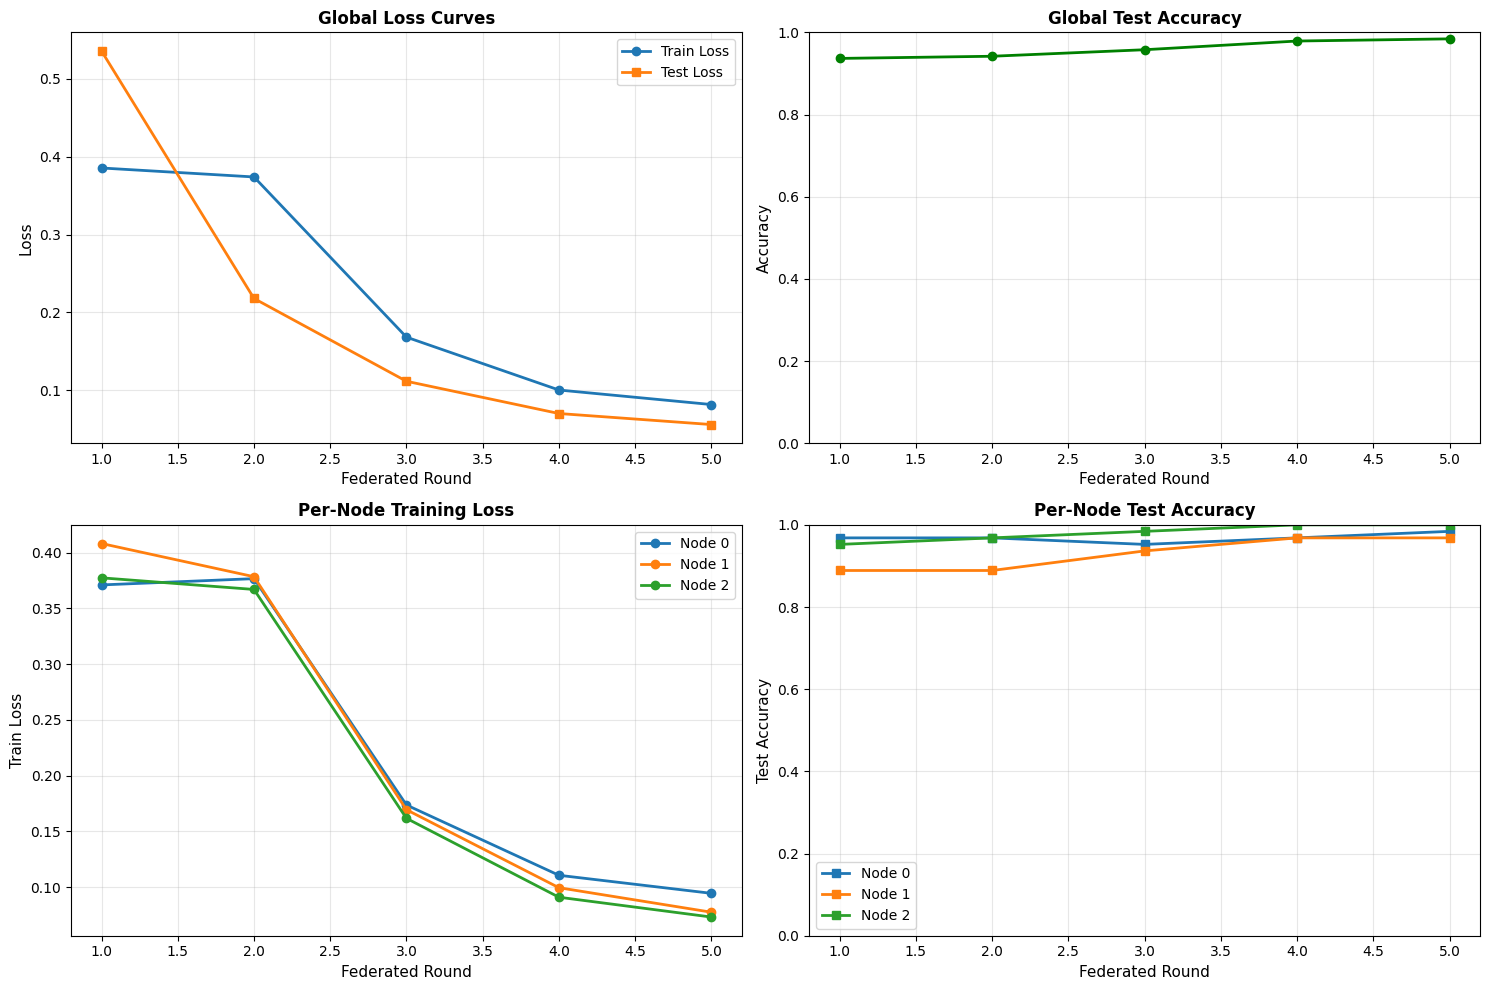

✓ Visualization saved to: models/federated_training_results.png


In [17]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

rounds = range(1, NUM_ROUNDS + 1)

# Plot 1: Loss curves
axes[0, 0].plot(rounds, history["train_loss"], marker='o', label="Train Loss", linewidth=2)
axes[0, 0].plot(rounds, history["test_loss"], marker='s', label="Test Loss", linewidth=2)
axes[0, 0].set_xlabel("Federated Round", fontsize=11)
axes[0, 0].set_ylabel("Loss", fontsize=11)
axes[0, 0].set_title("Global Loss Curves", fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy curve
axes[0, 1].plot(rounds, history["test_acc"], marker='o', color='green', linewidth=2)
axes[0, 1].set_xlabel("Federated Round", fontsize=11)
axes[0, 1].set_ylabel("Accuracy", fontsize=11)
axes[0, 1].set_title("Global Test Accuracy", fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# Plot 3: Per-node training loss
for node_id in range(NUM_NODES):
    axes[1, 0].plot(rounds, history["node_train_losses"][node_id], 
                    marker='o', label=f"Node {node_id}", linewidth=2)
axes[1, 0].set_xlabel("Federated Round", fontsize=11)
axes[1, 0].set_ylabel("Train Loss", fontsize=11)
axes[1, 0].set_title("Per-Node Training Loss", fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Per-node test accuracy
for node_id in range(NUM_NODES):
    axes[1, 1].plot(rounds, history["node_test_accs"][node_id], 
                    marker='s', label=f"Node {node_id}", linewidth=2)
axes[1, 1].set_xlabel("Federated Round", fontsize=11)
axes[1, 1].set_ylabel("Test Accuracy", fontsize=11)
axes[1, 1].set_title("Per-Node Test Accuracy", fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig("../models/federated_training_results.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to: models/federated_training_results.png")

## 6. Save Global Model

In [18]:
# Save the global model and training history
model_path = "../models/federated_global_model.pth"

torch.save({
    'model_state_dict': node_models[0].state_dict(),
    'vitals_dim': vitals_dim,
    'air_dim': air_dim,
    'weather_dim': weather_dim,
    'history': history,
    'config': {
        'num_rounds': NUM_ROUNDS,
        'num_nodes': NUM_NODES,
        'local_epochs': LOCAL_EPOCHS,
        'strategy': STRATEGY,
        'optimizer': 'Adam',
        'learning_rate': 1e-3
    }
}, model_path)

print(f"✓ Global model saved to: {model_path}")
print(f"\nModel info:")
print(f"  Input dimensions: vitals={vitals_dim}, air={air_dim}, weather={weather_dim}")
print(f"  Final accuracy: {history['test_acc'][-1]:.4f}")
print(f"  Training rounds: {NUM_ROUNDS}")

✓ Global model saved to: ../models/federated_global_model.pth

Model info:
  Input dimensions: vitals=6, air=5, weather=4
  Final accuracy: 0.9841
  Training rounds: 5


## 7. Model Summary & Next Steps

In [19]:
print("\n" + "="*70)
print("📊 FEDERATED LEARNING SUMMARY")
print("="*70)

print(f"\n✅ Training Configuration:")
print(f"   • Nodes: {NUM_NODES} (simulating hospitals/cities)")
print(f"   • Rounds: {NUM_ROUNDS}")
print(f"   • Local epochs: {LOCAL_EPOCHS}")
print(f"   • Strategy: {STRATEGY}")
print(f"   • Algorithm: FedAvg (Federated Averaging)")

print(f"\n📈 Final Performance:")
print(f"   • Global Test Accuracy: {history['test_acc'][-1]:.4f} ({history['test_acc'][-1]*100:.1f}%)")
print(f"   • Global Test Loss: {history['test_loss'][-1]:.4f}")
print(f"   • Accuracy Improvement: {(history['test_acc'][-1] - history['test_acc'][0]):.4f}")

print(f"\n🏥 Per-Node Performance (Final Round):")
for node_id in range(NUM_NODES):
    acc = history['node_test_accs'][node_id][-1]
    print(f"   • Node {node_id}: {acc:.4f} ({acc*100:.1f}%)")

print(f"\n💾 Saved Artifacts:")
print(f"   • Model: models/federated_global_model.pth")
print(f"   • Visualization: models/federated_training_results.png")

print(f"\n🎯 Next Steps:")
print(f"   1. Model Evaluation - Detailed metrics (precision, recall, F1, ROC)")
print(f"   2. Experiment Tracking - Integrate MLflow for experiment management")
print(f"   3. Deployment - Create FastAPI inference service")
print(f"   4. Monitoring - Add data drift detection")
print(f"   5. Dashboards - Build Streamlit apps for authorities & citizens")

print("\n" + "="*70)


📊 FEDERATED LEARNING SUMMARY

✅ Training Configuration:
   • Nodes: 3 (simulating hospitals/cities)
   • Rounds: 5
   • Local epochs: 2
   • Strategy: iid
   • Algorithm: FedAvg (Federated Averaging)

📈 Final Performance:
   • Global Test Accuracy: 0.9841 (98.4%)
   • Global Test Loss: 0.0561
   • Accuracy Improvement: 0.0476

🏥 Per-Node Performance (Final Round):
   • Node 0: 0.9841 (98.4%)
   • Node 1: 0.9683 (96.8%)
   • Node 2: 1.0000 (100.0%)

💾 Saved Artifacts:
   • Model: models/federated_global_model.pth
   • Visualization: models/federated_training_results.png

🎯 Next Steps:
   1. Model Evaluation - Detailed metrics (precision, recall, F1, ROC)
   2. Experiment Tracking - Integrate MLflow for experiment management
   3. Deployment - Create FastAPI inference service
   4. Monitoring - Add data drift detection
   5. Dashboards - Build Streamlit apps for authorities & citizens



## Experiments to Run (Future)

1. **Strategy Comparison**: Compare IID vs non-IID data distribution
2. **Node Scaling**: Test with 2, 3, 5, 10 nodes
3. **Hyperparameter Tuning**: Vary learning rate, local epochs, batch size
4. **Personalization**: Fine-tune global model on each node's local data
5. **Communication Efficiency**: Track bytes transferred per round
6. **Drift Detection**: Monitor data drift per node over rounds
7. **Privacy Analysis**: Add differential privacy mechanisms